# Exercise 4
*CS-E5885 Modeling Biological Networks* <br>
*1st Feb, 2023* <br>

In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp

## 0. Introduction

### Numerical solution of ODEs

Consider a dynamical system with state $\textbf{x}(t) \in \mathbb{R}_+^{2}$, where $x_1(t)$ and $x_2(t)$ are concentrations of molecules A and B at time $t \geq 0$, respectively. The initial concentrations are $\textbf{x}(0) = [2.2, 1.0]^{\top}$ and assumed to be known. The dynamics are modeled using a coupled ODE (ordinary differential equation) system

$$
\begin{align}
& \frac{\text{d}\textbf{x}(t)}{\text{d}t} = f(\textbf{x}(t), \textbf{k}) & (Eq. 1)
\end{align}
$$

where

$$
f(\bf{x}, \bf{k}) = 
\begin{bmatrix} 
f_1(\bf{x}, \bf{k}) \\
f_2(\bf{x}, \bf{k})
\end{bmatrix} =
\begin{bmatrix} 
2 x_1 - k_1 x_1 x_2 \\
k_1 x_1 x_2 - k_2 x_2
\end{bmatrix}
$$

and $\textbf{k} = [k_1, k_2]$ are deterministic rate constants. Below is an example that shows how to solve $\textbf{x}(t)$ numerically using [scipy.integrate.solve_ivp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html), with some given value of $\textbf{k}$ (`k_example`). 

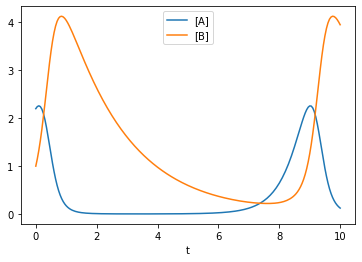

In [2]:
# This function implements f(x, k)
def odefun(x, k):
    """Differential function of the ODE system.
    
    :param x: a list with length 2, i.e. values of the dynamical variables
    :param k: parameters, a list with length 2
    :returns: dx/dt, a list with length 2
    """
    dx1_dt = 2.0*x[0] - k[0]*x[0]*x[1]
    dx2_dt = k[0]*x[0]*x[1] - k[1]*x[1]
    dx_dt = [dx1_dt, dx2_dt]
    return dx_dt

# Using scipy.integrate.solve_ivp() to solve x(t) in the interval [0, 10] with given an example value of k
x0 = [2.2, 1.0]
t_eval = np.linspace(0,10,201)
k_example = [1.5, 0.5]

fun = lambda t,y: odefun(x=y, k=k_example) # differential function with fixed k values
out = solve_ivp(fun, y0=x0, t_span=[0, max(t_eval)], t_eval=t_eval) # solve the initial value problem

# Plot solution
X_out = out.y.T
plt.figure()
plt.plot(t_eval, X_out[:, 0])
plt.plot(t_eval, X_out[:, 1])
plt.legend(['[A]', '[B]'])
plt.xlabel('t')
plt.show()

### Data for the exercise

In this exercise, we don't know the values of the parameters $\textbf{k}$ and wish to optimize them based on the below data. The first column of `Y_data` corresponds to $x_1(t)$ and second to $x_2(t)$.

In [3]:
t_data = np.linspace(1,10,20)
Y_data = np.array([
    [2.46453992, 3.60858988],
    [1.36147358, 2.94974486],
    [0.83659004, 2.42189492],
    [0.63479081, 1.21896289],
    [1.96550665, 0.79799601],
    [2.8, 1.2],
    [3.9317634,  1.85744158],
    [2.37791467, 3.43918307],
    [1.63918609, 3.56459394],
    [1.13540439, 2.03678334],
    [1.30275284, 1.52561854],
    [1.62360963, 1.17760926],
    [2.68444394, 0.98298436],
    [3.83887552, 1.88928201],
    [2.23165204, 3.46577548],
    [1.07424108, 2.4358289 ],
    [0.57951303, 1.70852535],
    [1.38550887, 1.13571176],
    [1.8, 1.1],
    [2.90236636, 1.2190146 ]])


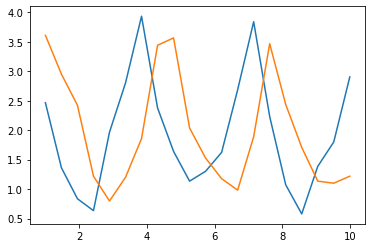

In [4]:
plt.plot(t_data,Y_data)

## 1. Target function (1 p)

To emphasis the dependency of the solution $\textbf{x}(t)$ on the parameters we now start denoting it by $\textbf{x}_\textbf{k}(t)$. We will be optimizing the parameters $\textbf{k}$ based on the data, by minimizing a target function which is 

$$
L(\textbf{k}) = \sum_{i=1}^{N} \| \textbf{y}_{i}^\top - \textbf{x}_{\textbf{k}}(t_i)\|^2
$$
where 

* $N$ is the number of observations
* $\textbf{y}_{i}$ is the $i$th row of `Y_data`
* $t_i$ is the $i$th value of `t_data`, and
* $\|\textbf{v}\| = \sqrt{v_1^2 + v_2^2}$ is the Euclidean norm of vector $\textbf{v}$.

**a)** Write a python function which evaluates the target function at given point $\textbf{k}$.

In [5]:
x0 = [2.2,1.0]

def target_function(k):
    """Sum of squared errors.
    :param k: Rate parameters. A list with length 2.
    :return: A real number.
    """
    t_eval = t_data

    fun = lambda t,y: odefun(x=y, k=k) # differential function with fixed k values
    out = solve_ivp(fun, y0=x0, t_span=[0, max(t_eval)], t_eval=t_eval) # solve the initial value problem
    X_out = out.y.T
    
    L = 0
    for i in range(len(Y_data)):
        error = Y_data[i,:] - X_out[i,:]
        squared_error = np.sqrt(error[0]**2 + error[1]**2)**2
        L = L + squared_error
    
    return L
        
    

**b)** What is the value of the target function at point $\textbf{k} = [1.1, 1.7]^{\top}$?

In [6]:
k=[1.1,1.7]
target_function(k)

20.038895399474683

**c)** Run the following block which visualizes the target function. What do you think are the optimal parameter values?

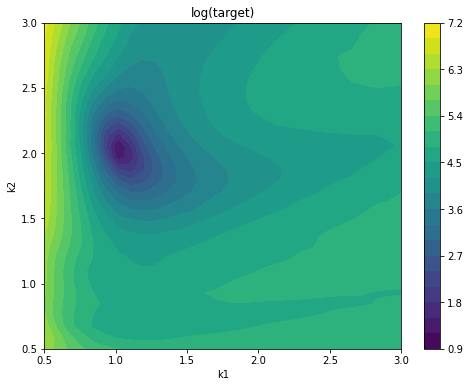

In [7]:
def target_grid(N=30):
    h = np.linspace(0.5, 3, N)
    x, y = np.meshgrid(h, h)
    z = np.zeros(x.shape)
    for i in range(0, N):
        for j in range(0, N):
            k_ij = [x[i,j], y[i,j]]
            z[i,j] = target_function(k_ij)
    return x, y, z
        
def plot_grid(x, y, z, show = True):
    plt.figure(figsize=(8,6))
    plt.contourf(x, y, np.log(z), levels = 20)
    plt.colorbar()
    plt.title('log(target)')
    plt.xlabel('k1')
    plt.ylabel('k2')
    if show:
        plt.show()

x_grid,y_grid,z_grid = target_grid()
plot_grid(x_grid,y_grid,z_grid)

Based on the graph, I think the most optimal values for k are [1.0, 2.0].

## 2. Gradient of the target function (3 p)

In reality the number of parameters could be very large and it would not be possible to infer them based on a plot/grid search like in the previous problem. We would need to use some optimization algorithm. Optimization algorithms typically require the gradient of the objective function. For our target function, the gradient can be written as

$$
\begin{align*}
\frac{\text{d}L(\textbf{k})}{\text{d}\textbf{k}} &= \sum_{i=1}^{N} \frac{\text{d}}{\text{d}\textbf{k}} \| \textbf{y}^\top_{i} - \textbf{x}_{\textbf{k}}(t_i)\|^2 = -2 \sum_{i=1}^{N} \left[ \frac{\text{d} \textbf{x}(t_i)}{\text{d}\textbf{k}} \right]^\top \left( \textbf{y}^\top_{i} - \textbf{x}_{\textbf{k}}(t_i) \right).
\end{align*}
$$

The problem is that we do not directly know the sensitivities $\textbf{s}(t_i) = \frac{\text{d}\textbf{x}_{\textbf{k}}(t_i)}{\text{d}\textbf{k}}$, i.e. information about how each $\textbf{x}_{\textbf{k}}(t_i)$ changes when the values of the parameters $\textbf{k}$ change.

They can be solved from an additional ODE given by the sensitivity equations

$$
 \frac{\text{d} \textbf{s}(t)}{\text{d}t} = \textbf{J}_x \textbf{s}(t) + \textbf{J}_k
$$

simultaneously with the original system (see Lecture 6). 

**a)** Write the Jacobian matrices $\textbf{J}_x =  \frac{\partial \textbf{f}}{\partial \textbf{x}}$ and $\textbf{J}_k =  \frac{\partial \textbf{f}}{\partial \textbf{k}}$ for our system in $Eq. 1$.

**b)** Complete the function below, which computes $\frac{\text{d} \tilde{\textbf{x}}(t)}{\text{d}t}$ so that

* $\tilde{x}_1$ is $x_1$
* $\tilde{x}_2$ is $x_2$ 
* $\tilde{x}_3$ is $\frac{d x_1}{d k_1}$
* $\tilde{x}_4$ is $\frac{d x_1}{d k_2}$
* $\tilde{x}_5$ is $\frac{d x_2}{d k_1}$
* $\tilde{x}_6$ is $\frac{d x_2}{d k_2}$


In [8]:
def odefun_extended(x_tilde, k):
    """Differential function of the extended ODE system.
    
    :param x: a list with length 6, where first 2 are values of the dynamical variables
        and rest are sensitivities
    :param k: a list with length 2
    :returns: dx_tilde/dt a list with length 6
    """
    s = np.array(x_tilde[2:]).reshape(2,2)
    x1 = x_tilde[0]
    x2 = x_tilde[1]    
    k1 = k[0]
    k2 = k[1]
    
    # Jacobian matrices
    Jx = np.array([[2-k1*x2, -k1*x1], [k1*x2, k1*x1-k2]])
    Jk = np.array([[-x1*x2, 0], [x1*x2, -x2]])

    # Compute derivative
    dx_dt = np.array([2*x1 - k1*x1*x2, k1*x1*x2 - k2*x2]).reshape(2,1)
    ds_dt = np.matmul(Jx,s) + Jk
    dx_tilde_dt = np.append(dx_dt, ds_dt).flatten()
    
    return dx_tilde_dt

**c)** Complete the below function which computes the gradient of the target function.

In [9]:
def target_grad(k):
    """Gradient of the target function.
    
    :param k: an array with length 2
    :returns: dL/dk, an array with length 2
    """
    N = len(t_data)
    s0 = np.array([0,0,0,0]) # we know that sensitivity at t=0 is zero because initial value is fixed
    x0_tilde = np.concatenate((x0, s0))
    t_ext = np.concatenate(([0.0], t_data)) # we add point t=0
    fun_extended = lambda t,y: odefun_extended(x_tilde=y,k=k)
    out = solve_ivp(fun_extended, y0=x0_tilde, t_span=[0, max(t_ext)], t_eval=t_ext)
    X_tilde = out.y.T[1:(N+1),:] # remove point at t=0

    # Compute and return gradient of the objective using the solved X_tilde
    dl_dk = [0]*N
    for i in range(N):
        dx_dt = X_tilde[i,2:].reshape(2,2)
        dl_dk[i] = np.matmul(dx_dt.T, (Y_data[i].T-X_tilde[i,0:2]))

    return -2*sum(dl_dk)

**d)** Run the following code which visualizes the gradient at one point.

[78.31020938  4.4370408 ]


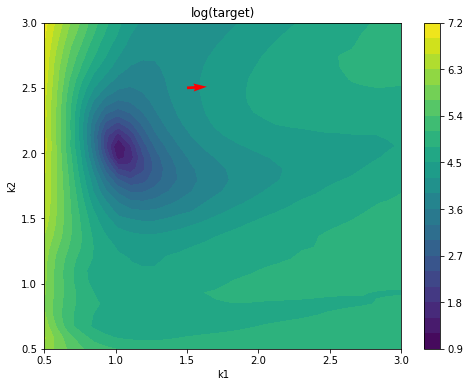

In [10]:
k = [1.5,2.5]
grad = target_grad(k)
print(grad)

plot_grid(x_grid,y_grid,z_grid, show=False)
plt.quiver(k[0], k[1], grad[0], grad[1], color = "red")
plt.show()

## 3. Gradient descent optimization (1 p)

**a)** Complete the below function which optimizes the parameters **k**. It should otherwise work like the gradient descent algorithm (Lecture  6) but you don't need to do the line search, and can instead use a fixed step size `r`.

In [11]:
def grad_descent(k0, n_iter, r):
    """Gradient descent optimization without line search.
    :param k0: Initial guess for the parameter values. List of length 2.
    :param n_iter: Number of iterations.
    :param r: Step size. Positive real number.
    :return: The optimization path in an array with shape [n_iter+1, len(k0)].
    """
    K_path = np.zeros((n_iter+1, len(k0)))
    K_path[0,:] = k0
    for i in range(n_iter):
        k = np.copy(K_path[i,:]) # current parameter values
        K_path[i+1,:] = k-r*target_grad(k) # update parameter values
#         if target_function(K_path[i+1,:]) > target_function(k):
#             K_path[i+1,:] = k

    return(K_path)
        

**b)** Run the optimization, starting from initial value `k0 = [2.0,1.5]`. Set number of iterations to 50 and use $r = 0.001$. Plot the optimization path using the function below.

[1.02773374 2.02235802]


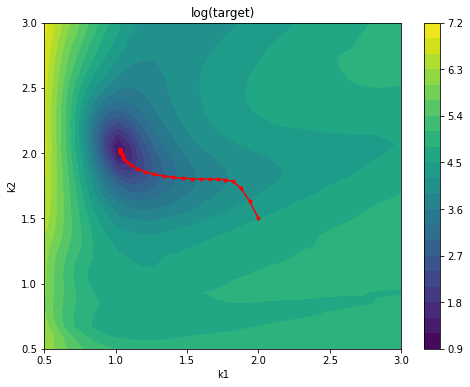

In [12]:
k0 = [2.0,1.5]
K_path = grad_descent(k0,n_iter=50, r=0.001)
print(K_path[len(K_path)-1,:])

def plot_path(K_path):
    plot_grid(x_grid, y_grid, z_grid,  show=False)
    plt.plot(K_path[:,0], K_path[:,1], 'r.-')
    plt.show()
    
plot_path(K_path)

**c)** What were the optimal parameter values that you found? Solve the ODE system with the optimal parameter values at 201 equally spaced points on the interval $t \in [0, 10]$ and plot the solution in separate panels for $x_1(t)$ and $x_2(t)$. Plot also the data in both panels. What happens if you instead start from `k0 = [2.0,0.5]`?

The optimal parameters are k = [1.02773374, 2.02235802].

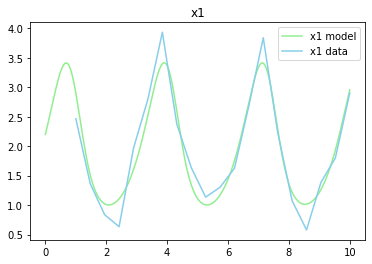

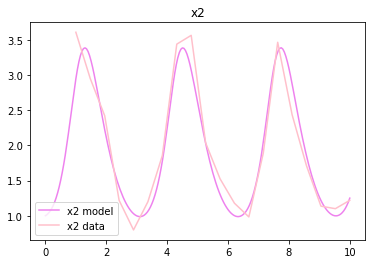

In [15]:
t_data_new = np.linspace(0,10,201)
k_optimal = [1.02773374, 2.02235802]
fun = lambda t,y: odefun(x=y, k=k_optimal)
out = solve_ivp(fun, y0=x0, t_span=[0, max(t_data_new)], t_eval=t_data_new)
X_out = out.y.T

plt.plot(t_data_new, X_out[:, 0],color="lightgreen")
plt.plot(t_data, Y_data[:, 0], color="skyblue")
plt.legend(["x1 model", "x1 data"])
plt.title("x1")
plt.show()

plt.plot(t_data_new, X_out[:, 1],color="violet")
plt.plot(t_data, Y_data[:, 1], color="pink")
plt.legend(["x2 model", "x2 data"])
plt.title("x2")
plt.show()

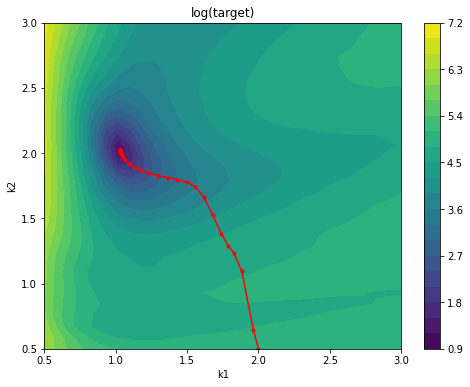

[1.02773375 2.02235797]


In [17]:
k0 = [2.0, 0.5]
K_path = grad_descent(k0, 50, 0.001)
plot_path(K_path)
print(K_path[len(K_path)-1,:])

Without the stopping condition, the function finds the same optimal parameters as with k = [2.0, 15].